In [8]:
from typing import *
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
import seaborn as sns
import pandas as pd
sns.set_style("whitegrid")
import requests

import math
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus
from torch.distributions import Distribution


from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from functools import reduce
from torch.distributions.bernoulli import Bernoulli

import IsoDatasets
from tqdm import tqdm
from torch.utils.data import DataLoader, random_split



import gzip
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


## Helper functions

In [9]:
def load_data_chunk(filename, chunk_size=1000):
    """ Load a chunk of data from a gzipped TSV file. """
    return pd.read_csv(filename, sep='\t', compression='gzip', chunksize=chunk_size)

def separate_ids_and_data(data):
    ids = data.iloc[:, 0]
    data = data.iloc[:, 1:]
    return ids, data

def create_data_loaders(data_dir, batch_size, train_percent=0.8, load_in_mem=False):
    full_dataset = IsoDatasets.Archs4GeneExpressionDataset(data_dir, load_in_mem)
    train_size = int(train_percent * len(full_dataset))
    test_size = len(full_dataset) - train_size

    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, test_dataloader

class ReparameterizedDiagonalGaussian(Distribution):
    """
    A distribution `N(y | mu, sigma I)` compatible with the reparameterization trick given `epsilon ~ N(0, 1)`.
    """
    def __init__(self, mu: Tensor, log_sigma:Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp()

    def sample_epsilon(self) -> Tensor:
        """`\eps ~ N(0, I)`"""
        return torch.empty_like(self.mu).normal_()

    def sample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (without gradients)"""
        with torch.no_grad():
            return self.rsample()

    def rsample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
        # z = mu + sigma * epsilon
        return self.mu + self.sigma * self.sample_epsilon()

    def log_prob(self, z: Tensor) -> Tensor:
        """return the log probability: log `p(z)`"""
        # Log probability for Gaussian distribution
        # log p(z) = -1/2 * [log(2*pi) + 2*log(sigma) + (z - mu)^2/sigma^2]
        return -0.5 * (torch.log(2 * torch.tensor(math.pi)) + 2 * torch.log(self.sigma) +
                       torch.pow(z - self.mu, 2) / torch.pow(self.sigma, 2))
    
    def count_csv_rows(filename):
        # If the file is gzip-compressed, decompress it first
        if filename.endswith('.gz'):
            with gzip.open(filename, 'rt', newline='') as csvfile:
                row_count = sum(1 for row in csvfile)
        else:
            # Specify the correct encoding (e.g., 'utf-8', 'latin-1', etc.)
            encoding = 'utf-8'  # Change to the appropriate encoding if needed
            with open(filename, 'r', newline='', encoding=encoding) as csvfile:
                row_count = sum(1 for row in csvfile)
        return row_count

## Load Data

In [10]:
# Define the file paths
archs4_path = "/dtu-compute/datasets/iso_02456/archs4_gene_expression_norm_transposed.tsv.gz"
gtex_gene_path = "/dtu-compute/datasets/iso_02456/gtex_gene_expression_norm_transposed.tsv.gz"
gtex_isoform_path = "/dtu-compute/datasets/iso_02456/gtex_isoform_expression_norm_transposed.tsv.gz"
gtex_anno_path = "/dtu-compute/datasets/iso_02456/gtex_gene_isoform_annoation.tsv.gz"
gtex_tissue_path = "/dtu-compute/datasets/iso_02456/gtex_annot.tsv.gz"

# hdf5 paths:
archs4_path = "/dtu-compute/datasets/iso_02456/hdf5-row-sorted/archs4_gene_expression_norm_transposed.hdf5"
gtex_gene_path = "/dtu-compute/datasets/iso_02456/hdf5-row-sorted/gtex_gene_expression_norm_transposed.hdf5"
gtex_isoform_path = "/dtu-compute/datasets/iso_02456/hdf5-row-sorted/gtex_isoform_expression_norm_transposed.hdf5"

num_genes = 18965
num_isoforms = 156958

num_genes, num_isoforms

(18965, 156958)

### Data Loader

In [11]:
# !zcat /dtu-compute/datasets/iso_02456/archs4_gene_expression_norm_transposed.tsv.gz | wc -l
print("archs4_path num rows: 167885")

archs4_path num rows: 167885


In [34]:
# Here is an example of loading the Archs4 gene expression dataset and looping over it
# If you have about 12GB of memory, you can load the dataset to memory using the argument load_in_mem=True

archs4_train_dataloader, archs4_test_dataloader = create_data_loaders(
    "/dtu-compute/datasets/iso_02456/hdf5/",
    batch_size=64,
    train_percent=0.8,
    load_in_mem=False  # Set to False to avoid MemoryError
)


In [35]:
genes = next(iter(archs4_train_dataloader))
print(genes.shape)
genes[0]

torch.Size([64, 18965])


tensor([3.2243, 0.0159, 1.3281,  ..., 7.6413, 3.5074, 5.5058])

## Building the model
When defining the model the latent layer must act as a bottleneck of information, so that we ensure that we find a strong internal representation. We initialize the VAE with 1 hidden layer in the encoder and decoder using relu units as non-linearity.

In [36]:
class VariationalAutoencoder(nn.Module):
    """A Variational Autoencoder with
    * a Bernoulli observation model `p_\theta(x | z) = B(x | g_\theta(z))`
    * a Gaussian prior `p(z) = N(z | 0, I)`
    * a Gaussian posterior `q_\phi(z|x) = N(z | \mu(x), \sigma(x))`
    """

    def __init__(self, input_shape:torch.Size, latent_features:int) -> None:
        super(VariationalAutoencoder, self).__init__()

        self.input_shape = input_shape
        self.latent_features = latent_features
        self.observation_features = np.prod(input_shape)


        # Inference Network
        # Encode the observation `x` into the parameters of the posterior distribution
        # `q_\phi(z|x) = N(z | \mu(x), \sigma(x)), \mu(x),\log\sigma(x) = h_\phi(x)`
        self.encoder = nn.Sequential(
            nn.Linear(in_features=self.observation_features, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            # A Gaussian is fully characterised by its mean \mu and variance \sigma**2
            nn.Linear(in_features=128, out_features=2*latent_features) # <- note the 2*latent_features
        )

        # Generative Model
        # Decode the latent sample `z` into the parameters of the observation model
        # `p_\theta(x | z) = \prod_i B(x_i | g_\theta(x))`
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=self.observation_features)
        )

        # define the parameters of the prior, chosen as p(z) = N(0, I)
        self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features])))

    def posterior(self, x:Tensor) -> Distribution:
        """return the distribution `q(x|x) = N(z | \mu(x), \sigma(x))`"""

        # compute the parameters of the posterior
        h_x = self.encoder(x)
        mu, log_sigma =  h_x.chunk(2, dim=-1)

        # return a distribution `q(x|x) = N(z | \mu(x), \sigma(x))`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)

    def prior(self, batch_size:int=1)-> Distribution:
        """return the distribution `p(z)`"""
        prior_params = self.prior_params.expand(batch_size, *self.prior_params.shape[-1:])
        mu, log_sigma = prior_params.chunk(2, dim=-1)

        # return the distribution `p(z)`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)

    def observation_model(self, z:Tensor) -> Distribution:
        """return the distribution `p(x|z)`"""
        px_logits = self.decoder(z)
        px_logits = px_logits.view(-1, *self.input_shape) # reshape the output
        return Bernoulli(logits=px_logits, validate_args=False)


    def forward(self, x) -> Dict[str, Any]:
        """compute the posterior q(z|x) (encoder), sample z~q(z|x) and return the distribution p(x|z) (decoder)"""

        # flatten the input
        x = x.view(x.size(0), -1)

        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.posterior(x)

        # define the prior p(z)
        pz = self.prior(batch_size=x.size(0))

        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        z = qz.rsample()

        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)

        return {'px': px, 'pz': pz, 'qz': qz, 'z': z}


    def sample_from_prior(self, batch_size:int=100):
        """sample z~p(z) and return p(x|z)"""

        # degine the prior p(z)
        pz = self.prior(batch_size=batch_size)

        # sample the prior
        z = pz.rsample()

        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)

        return {'px': px, 'pz': pz, 'z': z}


latent_features = 100
vae = VariationalAutoencoder(genes[0].shape, latent_features)
print(vae)

VariationalAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=18965, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=200, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=18965, bias=True)
  )
)


## Implement a module for Variational Inference

**Exercise 1**: implement `elbo` ($\mathcal{L}$) and `beta_elbo` ($\mathcal{L}^\beta$)

In [37]:
def reduce(x:Tensor) -> Tensor:
    """for each datapoint: sum over all dimensions"""
    return x.view(x.size(0), -1).sum(dim=1)

class VariationalInference(nn.Module):
    def __init__(self, beta:float=1.):
        super().__init__()
        self.beta = beta

    def forward(self, model:nn.Module, x:Tensor) -> Tuple[Tensor, Dict]:

        # forward pass through the model
        outputs = model(x)

        # unpack outputs
        px, pz, qz, z = [outputs[k] for k in ["px", "pz", "qz", "z"]]

        # evaluate log probabilities
        log_px = reduce(px.log_prob(x))
        log_pz = reduce(pz.log_prob(z))
        log_qz = reduce(qz.log_prob(z))

        # compute the ELBO with and without the beta parameter:
        # `L^\beta = E_q [ log p(x|z) ] - \beta * D_KL(q(z|x) | p(z))`
        # where `D_KL(q(z|x) | p(z)) = log q(z|x) - log p(z)`
        kl = log_qz - log_pz
        elbo = log_px - kl # <- your code here
        beta_elbo = log_px - self.beta * kl # <- your code here

        # loss
        loss = -beta_elbo.mean()

        # prepare the output
        with torch.no_grad():
            diagnostics = {'elbo': elbo, 'log_px':log_px, 'kl': kl}

        return loss, diagnostics, outputs


In [38]:
vi = VariationalInference(beta=1.0)
loss, diagnostics, outputs = vi(vae, genes)
print(f"{'loss':6} | mean = {loss:10.3f}, shape: {list(loss.shape)}")
for key, tensor in diagnostics.items():
    print(f"{key:6} | mean = {tensor.mean():10.3f}, shape: {list(tensor.shape)}")

loss   | mean =  13172.390, shape: []
elbo   | mean = -13172.390, shape: [64]
log_px | mean = -13148.637, shape: [64]
kl     | mean =     23.753, shape: [64]


## Training and Evaluation

### Initialize the model, evaluator and optimizer

In [39]:
from collections import defaultdict
# define the models, evaluator and optimizer

# VAE
latent_features = 500
vae = VariationalAutoencoder(genes[0].shape, latent_features)

# Evaluator: Variational Inference
beta = 1
vi = VariationalInference(beta=beta)

# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# define dictionary to store the training curves
training_data = defaultdict(list)
validation_data = defaultdict(list)

epoch = 0

### Training Loop

#### Plotting Guide

- **1st Row**: Reproducing the figure from the beginning of the Notebook.
  - (Left) Data.
  - (Middle) Latent space: the large gray disk represents the prior (radius = $2\sigma$), each point represents a latent sample $\mathbf{z}$. The smaller ellipses represent the distributions $q_\phi(\mathbf{z} | \mathbf{x})$ (radius = $2\sigma$). When using $\geq 2$ latent features, dimensionality reduction is applied using t-SNE, and only samples $\mathbf{z} \sim q_\phi(\mathbf{z} | \mathbf{x})$ are displayed.
  - (Right) Samples from $p_\theta(\mathbf{x} | \mathbf{z}$).

- **2nd Row**: Training curves.

- **3rd Row**: Latent samples.
  - (Left) Prior samples $\mathbf{x} \sim p_\theta(\mathbf{x} | \mathbf{z}), \mathbf{z} \sim p(\mathbf{z})$.
  - (Middle) Latent Interpolations. For each row: $\mathbf{x} \sim p_\theta(\mathbf{x} | t \cdot \mathbf{z}_1 + (1-t) \cdot \mathbf{z}_2), \mathbf{z}_1, \mathbf{z}_2 \sim p(\mathbf{z}), t=0 \dots 1$.
  - (Right): Sampling $\mathbf{z}$ from a grid [-3:3, -3:3] $\mathbf{x} \sim p_\theta(\mathbf{x} | \mathbf{z}), \mathbf{z} \sim \text{grid}(-3:3, -3:3)$ (only available for 2D latent space).

**NOTE**: This may take a while on CPU.


In [40]:
print(torch.__version__)
print(torch.version.cuda)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")

1.10.2+cu102
10.2
>> Using device: cpu


In [42]:
train_loader = archs4_train_dataloader
test_loader = archs4_test_dataloader

In [47]:
num_epochs = 1 # 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")

vae = vae.to(device)

epoch = 0
while epoch < num_epochs:
    epoch += 1
    training_epoch_data = defaultdict(list)
    vae.train()

    # Wrapping the train_loader with tqdm
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [Train]")
    for x in train_loader_tqdm:
        x = x.to(device)

        loss, diagnostics, outputs = vi(vae, x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        for k, v in diagnostics.items():
            training_epoch_data[k] += [v.mean().item()]

        # Update tqdm bar with loss info, if needed
        train_loader_tqdm.set_postfix(loss=loss.item())

    for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

    with torch.no_grad():
        vae.eval()

        # Wrapping the test_loader with tqdm
        test_loader_tqdm = tqdm(test_loader, desc=f"Epoch {epoch}/{num_epochs} [Test]")
        x = next(iter(test_loader_tqdm))
        x = x.to(device)

        loss, diagnostics, outputs = vi(vae, x)

        for k, v in diagnostics.items():
            validation_data[k] += [v.mean().item()]


>> Using device: cpu


Epoch 1/1 [Test]:   0%|          | 0/525 [00:00<?, ?it/s]


In [62]:
print("It takes around 8 min per epoch")

It takes around 8 min per epoch


In [ ]:
# Save the model to a file
torch.save(vae.state_dict(), 'vae_model.pth')

In [ ]:
input_shape = vae.input_shape
input_shape = torch.Size([18965])
input_shape

torch.Size([18965])

In [ ]:
# Load the model from a file
loaded_vae = VariationalAutoencoder(input_shape, latent_features)
loaded_vae.load_state_dict(torch.load('vae_model.pth'))


## Evaluate model

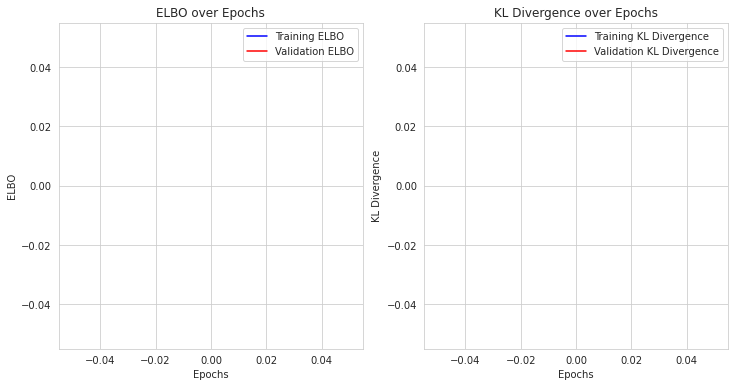

In [50]:
# Set up a figure and axis for the plots
plt.figure(figsize=(12, 6))

# Plot ELBO
plt.subplot(1, 2, 1)
plt.plot(training_data['elbo'], label='Training ELBO', color='blue')
plt.plot(validation_data['elbo'], label='Validation ELBO', color='red')
plt.xlabel('Epochs')
plt.ylabel('ELBO')
plt.title('ELBO over Epochs')
plt.legend()

# Plot KL Divergence
plt.subplot(1, 2, 2)
plt.plot(training_data['kl'], label='Training KL Divergence', color='blue')
plt.plot(validation_data['kl'], label='Validation KL Divergence', color='red')
plt.xlabel('Epochs')
plt.ylabel('KL Divergence')
plt.title('KL Divergence over Epochs')
plt.legend()

# Display the plot
plt.show()


In [51]:
# Sample from the prior
sampled_data = vae.sample_from_prior(batch_size=10)
generated_samples = sampled_data['px'].mean  # Assuming Bernoulli distribution

generated_samples.shape


torch.Size([10, 18965])

In [56]:
from sklearn.manifold import TSNE

# Sample a batch from your data
x = next(iter(test_loader))
x = x.to(device)

# Forward pass through the VAE
outputs = vae(x)
z = outputs['z'].cpu().detach().numpy() # z is the latent space
print(f"Latent space size: {z.shape[1]}")

Latent space size: 500


In [57]:
# Forward pass through the VAE
reconstructed_data = outputs['px'].mean  # Assuming Bernoulli distribution

# Compare original 'x' and 'reconstructed_data' visually or with a metric
reconstructed_data.shape

torch.Size([64, 18965])

Summary:
- Subplots using posterior samples:
 - Latent Samples (Row 1, Column 2)
 - Reconstruction (Row 1, Column 3)
- Subplots using prior samples:
 - Samples (Row 3, Column 1)
 - Latent Interpolations (Row 3, Column 2)
 - Samples from a grid (Row 3, Column 3)

Define training function to avoid repeating code:

In [63]:
def train_vae_model(vae, train_loader, test_loader, optimizer, num_epochs=100, device="cpu", beta=1.0):
    """
    Train the VAE model and evaluate.

    Parameters:
    - vae: The VAE model to train.
    - train_loader: DataLoader for the training data.
    - test_loader: DataLoader for the test data.
    - optimizer: Optimizer to use for training.
    - num_epochs: Number of epochs to train for.
    - device: Device to train on. Either "cpu" or "cuda".

    Returns:
    - training_data: Dictionary containing training diagnostics.
    - validation_data: Dictionary containing validation diagnostics.
    """

    # Initialize the evaluator and data storage for diagnostics
    vi = VariationalInference(beta=beta)
    training_data = defaultdict(list)
    validation_data = defaultdict(list)
    epoch = 0

    # Move the model to the desired device
    vae = vae.to(device)
    
    # Training loop
    while epoch < num_epochs:
        epoch += 1
        training_epoch_data = defaultdict(list)
        vae.train()

        # Wrapping the train_loader with tqdm
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [Train]")
        for x in train_loader_tqdm:
            x = x.to(device)

            loss, diagnostics, outputs = vi(vae, x)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            for k, v in diagnostics.items():
                training_epoch_data[k] += [v.mean().item()]

            # Update tqdm bar with loss info, if needed
            train_loader_tqdm.set_postfix(loss=loss.item())

        for k, v in training_epoch_data.items():
            training_data[k] += [np.mean(training_epoch_data[k])]

        with torch.no_grad():
            vae.eval()

            # Wrapping the test_loader with tqdm
            test_loader_tqdm = tqdm(test_loader, desc=f"Epoch {epoch}/{num_epochs} [Test]")
            x = next(iter(test_loader_tqdm))
            x = x.to(device)

            loss, diagnostics, outputs = vi(vae, x)

            for k, v in diagnostics.items():
                validation_data[k] += [v.mean().item()]

    ## Plot metrics
    # Set up a figure and axis for the plots
    plt.figure(figsize=(12, 6))

    # Plot ELBO
    plt.subplot(1, 2, 1)
    plt.plot(training_data['elbo'], label='Training ELBO', color='blue')
    plt.plot(validation_data['elbo'], label='Validation ELBO', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('ELBO')
    plt.title('ELBO over Epochs')
    plt.legend()

    # Plot KL Divergence
    plt.subplot(1, 2, 2)
    plt.plot(training_data['kl'], label='Training KL Divergence', color='blue')
    plt.plot(validation_data['kl'], label='Validation KL Divergence', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('KL Divergence')
    plt.title('KL Divergence over Epochs')
    plt.legend()

    # Display the plot
    plt.show()

    return training_data, validation_data

latent_features = 500
vae = VariationalAutoencoder(genes[0].shape, latent_features)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# training_data, validation_data = train_vae_model(vae, train_loader, test_loader, optimizer, num_epochs=100, device=device, beta=1.0)

In [64]:
training_data, validation_data = train_vae_model(vae, train_loader, test_loader, optimizer, num_epochs=5, device=device, beta=1.0)

Epoch 1/5 [Train]:  36%|███▋      | 762/2099 [02:33<05:07,  4.34it/s, loss=nan]      

# Analyzing the VAE

## Mandatory Exercises

### Exercise 1.

1. Implement the class `ReparameterizedDiagonalGaussian` (`log_prob()` and `rsample()`).
2. Import the class `Bernoulli`
3. Implement the class `VariationalInference` (computation of the `elbo` and `beta_elbo`).

### Exercise 2.

**Trainnig and Evaluating a VAE model**

1. Why do we use the reparameterization trick?
2. What available metric can you use to estimate the marginal likelihood ($p_\theta(\mathbf{x})$) ?
3. In the above plots, we display numerous model samples. If you had to pick one plot, which one would you pick to evaluate the quality of a VAE (i.e. using posterior samples $\mathbf{z} \sim q_\phi(\mathbf{z} | \mathbf{x})$ or prior samples $\mathbf{z} \sim p(\mathbf{z})$) ? Why?.
4. How could you exploit the VAE model for classification?

**Answers**:
1. The reparameterization trick is used to make the variational autoencoder's latent variables differentiable, allowing for backpropagation during the training process.
2. Monte-Carlo estimate is computationally challenging due to its high variance and the numerically instability, so we can use ELBO.
3.  The choice between the two depends on the primary goal of using the VAE:
 - If the primary goal is data reconstruction, then evaluating using the posterior samples would be more relevant. The quality and fidelity of reconstructed images would be the focus.
 - If the primary goal is data generation (e.g., generating new images that resemble the training data distribution), then evaluating using the prior samples would be more appropriate. The diversity, novelty, and quality of generated images would be the focus.

 However, for a holistic evaluation of a VAE, which aims to both encode and decode data efficiently, I would lean towards the posterior samples. This is because the core functionality of a VAE is its ability to encode data into a latent space and then decode it back. If this reconstruction is poor, then even if it generates reasonable outputs from the prior, it's not effectively serving its dual purpose. So I would pick the reconstruction plot (Row 1, Column 3). However, I personally really like the plot (Row 3, Column 3) to get an idea of the latent space.
4. A couple ways to leverage a VAE for classification tasks are:
 - Latent Space Classification for Dimensionality Reduction: Once the VAE is trained, we can encode the data into the latent space and then train a classifier (like an SVM or neural network) on the latent representations. This dimensionality reduction could help reduce overfitting and model complexity.
 - Semi-supervised Learning: VAEs can be particularly beneficial in semi-supervised scenarios, where labeled data is limited. The generative aspect of the VAE can leverage unlabeled data to improve the quality of the latent space, which can then aid classification on the small labeled dataset.
  


### Exercise 3.

**Experiment with the VAE model.**

1. Experiment with the number of layers and activation functions in order to improve the reconstructions and latent representation. What solution did you find the best and why?
2. Try to increase the number of digit classes in the training set and analyze the learning curves, latent space and reconstructions. For which classes and why does the VAE fail in reconstructing?  *HINT: Try the combination: `classes=[0, 1, 4, 9]`, to see how well VAE can separate these digits in the latent representation and reconstructions.*
3. Increase the number of units in the latent layer. Does it increase the models representational power and how can you see and explain this? How does this affect the quality of the reconstructions?

**Answers**:

1. We tried going deeper by adding 1 and 2 layers without seeing much difference. However, if we go shallower by removing one layer both the reconstruction and generative results get worse, though we can still recongnize some digits.
As for the activation functions we tried LeakyRelu with pretty much the same results, maybe slightly worst. The plots are available at the end of the notebook.
2. The VAE struggles reconstructing the digit 9 and while some generated digits look correct, others don't. Again, the results for this and further tests are available in the Annex at the end of the notebook.
3. Increasing the number of units in the latent layer to 4 improved the model reconstruction and generation capabilities, where it still has some trouble differentiating between 9 and 4 but it performs better than before. This happens because when we increase the units, the latent space becomes capable of capturing more complex patterns and nuances in the data.

### Exercise 4.

**Analyze the purpose of the KL-term and the $\beta$ parameter.**

1. How does the KL-term, $\mathcal{D}_{\operatorname{KL}}\left(q_\phi(\mathbf{z}|\mathbf{x})\ |\ p(\mathbf{z})\right)$, work as a regulariser on the distributions over latent variables? *HINT*: When maximising the ELBO, the probability-distance measure is minimised $\operatorname{KL} \rightarrow 0$ so that $q(z|x) \rightarrow p(z) = \mathcal{N}(z|0,I)$ for all examples, x. At $\operatorname{KL} = 0$ variations in x stops having an affect on the latent distribution and latent units are all described by the same distribution, $\mathcal{N}(z|0,I)$, so they produce a noisy output without signal (i.e. $\mathbf{z}=\epsilon \sim \mathcal{N}(0,I)$) to the decoder.
2. Try removing the KL-term (using the $\beta$ parameter) and analyze what happens during training, in the learning curves, latent representation and reconstructions compared to before removing it.
3. What does the loss reduces to? Explain how this can affect a VAE. *HINT*: Compare loss function for AE and VAE, and remember that we can use the pixel-wise binary crossentropy error as the loss in the AEs and for the reconstruction error, $\log p_\theta(\mathbf{x}|\mathbf{z}) = \log \mathcal{B}(\mathbf{x} | g_\theta(z))$, in VAEs.
4. Experiment with different $\beta$ values (e.g. [0.1, 10, 50]) and explain how this affects the reconstruction quality and the latent representations. *HINT* what is the tradeoff between reconstruction error ($\log p_\theta(\mathbf{x} | \mathbf{z})$) and the KL term?

**Answers**:

1. The KL-term, measures the divergence between two distributions: the approximate posterior and the prior, which is typically a standard normal distribution N(0,I). As the ELBO is maximized, the KL-term aims to be minimized. When it reaches 0, it indicates that the approximate posterior is the same as the prior. This means that the latent variables are not being influenced by the input data x and are essentially just noise sampled from N(0,I). Thus, the KL-term acts as a regularizer by ensuring that the latent representations don't stray too far from a prior belief (which is the standard normal distribution in most VAEs). Without this term, the latent variables might fit too closely to the training data, leading to overfitting.
2. By removing the KL-term (setting $\beta$=0), the VAE doesn't have any regularization on the latent space. This means the model focuses solely on the reconstruction error. We can observe:
 - The latent representation is probably more overfitted to the training data.
 - The reconstructions might be sharper initially but could lead to overfitting, where it performs well on training data but poorly on unseen data.

 Also for this part we experimented errors during the execution, only for beta=0. When we went above 40 epochs, most of the times we got a Cuda error that can be seen in the Annex. Not sure of why this happens and if the student reading this have any idea I would appreciate the feedback.
3. Without the KL-term, the VAE loss reduces to just the reconstruction error. In this scenario, the VAE becomes more like a traditional autoencoder (AE). This can lead to overfitting more easily just like an AE.
4. We can see the following differences:
 - A smaller $\beta$ (e.g., 0.1): Puts less emphasis on the KL-term, leading to better reconstructions but poorer generalization and more complex latent representations.
 - $\beta$ =1: This is the standard VAE, which balances reconstruction with regularization from the KL-term.
 - A larger $\beta$ (e.g., 10, 50): Puts more emphasis on the KL-term, leading to simpler latent representations but potentially worse reconstructions. But for $\beta$=50 specifically, both reconstructions and generations are diffuse and bad.

 The trade-off is that As $\beta$ increases, the model prioritizes making the approximate posterior close to the prior, often at the expense of reconstruction quality. Conversely, as $\beta$ decreases, the model prioritizes reconstruction, potentially at the expense of generalization.

